In [1]:
# import packages
import cv2
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_curve
import skimage
from skimage.filters import try_all_threshold, threshold_otsu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, euclidean, cdist
import os
import requests
import sys
import random
import itertools
from typing import Tuple
from PIL import Image, ImageDraw, ImageFont
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
BACKGROUNDS_PATH = r"data/backgrounds"
MRZs_PATH = r"data/mrzs.txt"
OUTPUT_PATH = r"Synthetic_Rec_En_V2"
FONTS_PATH = r"data/fonts/en_fonts"
MAX_NUM_WORDS = 7
OCR_MODEL_INPUT_SHAPE = (640, 32)

OUTPUT_TRAIN_PATH = os.path.join(OUTPUT_PATH, "train")
OUTPUT_TEST_PATH = os.path.join(OUTPUT_PATH, "test")
os.makedirs(OUTPUT_TRAIN_PATH, exist_ok=True)
os.makedirs(OUTPUT_TEST_PATH, exist_ok=True)

BACKGROUNDS = []
for bg_name in os.listdir(BACKGROUNDS_PATH):
    BACKGROUNDS.append(os.path.join(BACKGROUNDS_PATH, bg_name))
        
print("Total backgrounds found:", len(BACKGROUNDS))

# download a list of words for use as background text
word_site = "https://www.mit.edu/~ecprice/wordlist.100000"
response = requests.get(word_site)
WORDS = [x.decode() for x in response.content.splitlines()]


# list of font types to exclude
FONTS_LIST = []
FONTS_WEIGHTS = []
for font_path in glob.glob(os.path.join(FONTS_PATH, "**", "*.ttf"), recursive=True):
    FONTS_LIST.append(font_path)    
    if "Passport" in font_path:
        FONTS_WEIGHTS.append(2)
    elif "Visa" in font_path:
        FONTS_WEIGHTS.append(5)
    else:
        FONTS_WEIGHTS.append(1)

MRZs = []
with open(MRZs_PATH, "r") as reader:
    MRZs = [r.replace("\n", "").strip() for r in reader.readlines()]

Total backgrounds found: 101


In [3]:
from random import randint
import string
from PIL import ImageOps, ImageChops, ImageFilter
from datetime import datetime, timedelta


import math
def padImage(img):
    img = np.array(img.convert('RGB'), dtype=np.uint8)
    h, w = img.shape[:2]
    ratio = w / float(h)
    if math.ceil(OCR_MODEL_INPUT_SHAPE[1] * ratio) > OCR_MODEL_INPUT_SHAPE[0]:
        resized_w = OCR_MODEL_INPUT_SHAPE[0]
    else:
        resized_w = int(math.ceil(OCR_MODEL_INPUT_SHAPE[1] * ratio))
    resized_image = cv2.resize(img, (resized_w, OCR_MODEL_INPUT_SHAPE[1]), interpolation=cv2.INTER_AREA)
    padImg = np.zeros((OCR_MODEL_INPUT_SHAPE[1], OCR_MODEL_INPUT_SHAPE[0], 3), dtype=np.uint8)
    padImg[:, :resized_w] = resized_image
    return Image.fromarray(padImg)

def generate_random_date():
    # Generate a random year, month, and day
    year = random.randint(1900, 2100)
    month = random.randint(1, 12)
    # Generate a random day based on the selected month (and considering leap years)
    max_day = (datetime(year, month % 12 + 1, 1) - timedelta(days=1)).day
    day = random.randint(1, max_day)
    # Create a datetime object with the generated date
    date_obj = datetime(year, month, day)
    # Choose different date formats
    formats = [
        "%Y-%m-%d",    # YYYY-MM-DD
        "%d-%m-%Y",    # DD-MM-YYYY
        "%m-%d-%Y",    # MM-DD-YYYY
        "%Y/%m/%d",    # YYYY/MM/DD
        "%d/%m/%Y",    # DD/MM/YYYY
        "%m/%d/%Y",    # MM/DD/YYYY
        "%b %d, %Y",   # Abbreviated month, day, year (e.g., Jan 13, 2023)
        "%B %d, %Y"    # Full month name, day, year (e.g., January 13, 2023)
    ]
    # Choose a random format
    date_format = random.choice(formats)
    # Return the formatted date string
    return date_obj.strftime(date_format)

def get_pil_font(font_list, font_size=22):
    # Randomly select a font from a list of common fonts
    font_path = random.choices(FONTS_LIST, FONTS_WEIGHTS, k=1)[0]
    font = ImageFont.truetype(font_path, font_size)    
    return font, font_path


def add_background(size):
    index_random = random.randint(0, len(BACKGROUNDS) - 1)
    img = Image.open(BACKGROUNDS[index_random])
    img = img.resize(size)
    draw = ImageDraw.Draw(img)
    return img


# Function to add light reflection
# Function to add random light reflection patches
def add_random_light_reflection(image, num_patches=20):
    image = np.array(image, dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    height, width = image.shape[:2]
    mask = np.zeros((height, width, 3), dtype='float32')
    # Calculate base intensity factor based on the width of the image
    base_intensity = 0.5 * (1 / (width))  # Adjust the divisor as needed for your images
    for _ in range(num_patches):
        # Randomly determine the size and position of each reflection patch
        patch_width = int(random.uniform(0.25, 0.8) * width)
        patch_height = int(random.uniform(0.6, 1) * height)
        x_start = random.randint(0, width - patch_width)
        y_start = random.randint(0, height - patch_height)
        # Random intensity for the reflection
        intensity = random.uniform(0.1, base_intensity)
        # Create the reflection patch
        for i in range(patch_height):
            for j in range(patch_width):
                dist = ((i - patch_height / 2) ** 2 + (j - patch_width / 2) ** 2) ** 0.5
                max_dist = (patch_height ** 2 + patch_width ** 2) ** 0.5 / 2
                val = intensity * (1 - dist / max_dist)
                mask[y_start + i, x_start + j] += val    
    # Clip mask values to be between 0 and 1
    mask = np.clip(mask, 0, 1)
    # Ensure the mask is the same type as the input image
    mask = (mask * 255).astype('uint8')
    # Apply the mask to the image
    reflected_image = cv2.addWeighted(image, 1, mask, 0.5, 0)
    reflected_image = Image.fromarray(reflected_image).convert('RGB')
    return reflected_image


def get_sample(max_num_words, fonts, add_reflection_effect=True, text=None, font=None):
    isText = True
    toCase = str.upper
    
    font_size = random.randint(44, 56)
    if font is None:
        font, font_path = get_pil_font(fonts, font_size=font_size)
        
    if text is None:
        type_prob = random.uniform(0, 1)
        toCase = None
        isText = False
        if type_prob >= 0.5:
            # generate text
            num_words = random.randint(1, max_num_words)
            text = (random.randint(1, 3) * ' ').join(random.sample(WORDS, num_words))
            toCase = random.choices(
                population=[str.upper, str.lower, str.capitalize, str.title],
                weights=[0.5, 0.3, 0.1, 0.2],
                k=1
            )[0]
            text = toCase(text)
            if random.uniform(0, 1) > 0.8:
                for font__ in ["GROSTE.ttf", "VTBULLET", "atwriter.ttf"]:
                    if font__ in font_path:
                        punct = ""
                        break
                    else:
                        punct = random.choice(string.punctuation)
                        
                si = random.choice([*[i for i, x in enumerate(text) if x == ' '], *[0, len(text) - 1]])
                ps = random.choice([f' {punct}', f' {punct} ', f'{punct} '])
                text = text[:si] + ps + text[si + 1:]

            # add specified chars to the words randomly
            if random.uniform(0, 1) > 0.7 and toCase == str.upper:
                for _ in range(3):
                    char = random.choice(['I', 'Q', 'W', 'M', 'V', 'X', 'B', 'L', 'T', 'AA', '3'])
                    si = random.choice([*[i for i, x in enumerate(text) if x == ' '], *[0, len(text) - 1]])
                    ps = random.choice([f' {char}', f'{char} '])
                    text = text[:si] + ps + text[si + 1:]            
            isText = True
            
        elif type_prob > 0.3:
            # generate MRZs
            text = random.choice(MRZs)
        elif type_prob > 0.15:
            text = generate_random_date()
        else:
            # generate number
            l = []
            for _ in range(random.randint(1, 15)):
                if random.random() > 0.2:
                    letter = string.digits[random.randint(0, 9)]
                else:
                    letter = string.ascii_uppercase[random.randint(0, 25)]
                l.append(letter)
            text = ''.join(l)
    
    
    textsize = font.getsize(text)    
    letter_spacing = 0
    # add random spacing
    if isText and toCase == str.upper:
        if random.random() > 0.4:
            letter_spacing = random.randint(1, 7)
    
    # get image size
    img_w, img_h = 0, 0
    for char in text:
        char_width, char_height = font.getsize(char)
        img_w += char_width + letter_spacing
        img_h = max(char_height, img_h)
            
    offset_x, offset_y = random.randint(2, 8), random.randint(2, 4)
    size = (img_w + offset_x, img_h + offset_y)

    img = add_background(size) if random.uniform(0, 1) > 0.2 else Image.new('L', size, color='white')
    draw = ImageDraw.Draw(img)
    
    # Initial x and y positions
    x, y = random.randint(offset_x//2.5, offset_x//1.5) , random.randint(offset_y//10, offset_y//2.5)
    # Draw each character with custom horizontal spacing and, slight location change in y
    ofst_y__ = (img_h - char_height) / len(text)
    ofst_y__ = (random.choice([1, -1]) *  ofst_y__)
    for char in text:
        draw.text((x, y), char, fill="black", font=font, align="center")
        char_width, _ = draw.textsize(char, font=font)
        x += char_width + letter_spacing
        y += ofst_y__
    
    _, font_name = os.path.split(font_path)
    if font_name in [
        "Angsana New Bold.ttf", "TravelingTypewriter.ttf"
    ]:
        img = img.filter(ImageFilter.GaussianBlur(1))
    else:
        img = img.filter(ImageFilter.GaussianBlur(2))
    
    blur_prob=0.6
    if random.uniform(0, 1) > blur_prob:
        blur_intensity = random.uniform(0.6, 1)
        img = img.filter(ImageFilter.GaussianBlur(blur_intensity))
    
    # rotate the image by some angle
    if random.random() > 0.6:
        r = (0.5, 1) if len(text.split()) < 4 else (0.2, 0.6)
        img = img.rotate(
            random.choice([random.uniform(-r[0], -r[1]), random.uniform(*r)]), 
            resample=Image.Resampling.BICUBIC, 
            expand=1, 
            fillcolor='black'
        )
    
    # resize image randomly
    new_size = None
    if random.random() > 0.7:
        resize_factor = random.uniform(0.7, 1)
        w, h = img.size
        new_size = (int(w * resize_factor), int(h * resize_factor))
    else:
        if add_reflection_effect:
            # add glare effect
            if len(text.split()) < 6:
                img = add_random_light_reflection(img, num_patches=10)
    
    # stretching both sides
    if random.random() > 0.6:
        w, h = new_size if new_size is not None else img.size
        if random.random() > 0.5:
            new_h = h + int(h * random.uniform(0.1, 0.3))
        else:
            new_h = h - int(h * random.uniform(0.05, 0.2))   
        img = img.resize((w, new_h))
    else:
        if new_size is not None:
            img = img.resize(new_size)
    
    # remove the extra spaces if any
    text = ' '.join(text.split())
    return text, img

### Visualize

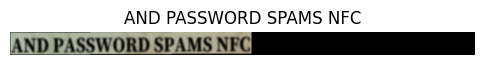

In [4]:
# list of font types to exclude
# FONTS_LIST = []
# FONTS_WEIGHTS = []
# for font_path in glob.glob(os.path.join(FONTS_PATH, "**", "*.ttf"), recursive=True):
#     FONTS_LIST.append(font_path)    
#     if "Passport" in font_path:
#         FONTS_WEIGHTS.append(2)
#     else:
#         FONTS_WEIGHTS.append(1)
    
# for font_path in FONTS_LIST:
#     print(font_path)
#     font = ImageFont.truetype(font_path, 16)
    
#     MAX_NUM_WORDS = 7
#     plt.figure(figsize=(6, 2))
#     text, img = get_sample(MAX_NUM_WORDS, FONTS_LIST, text="ABCQWERTYUI abcasdfj 123456790 /?-+@#$%^&*}{][", font=font)

#     # img = img.rotate(-1, resample=Image.Resampling.BICUBIC, expand=1, fillcolor='black')
#     plt.imshow(padImage(img))
#     plt.title(text)
#     plt.axis("off")
#     plt.show()


plt.figure(figsize=(6, 2))
text, img = get_sample(MAX_NUM_WORDS, FONTS_LIST, add_reflection_effect=False)

# img = img.rotate(-1, resample=Image.Resampling.BICUBIC, expand=1, fillcolor='black')
padImg = padImage(img)
plt.imshow(padImg)
plt.title(text)
plt.axis("off")
plt.show()

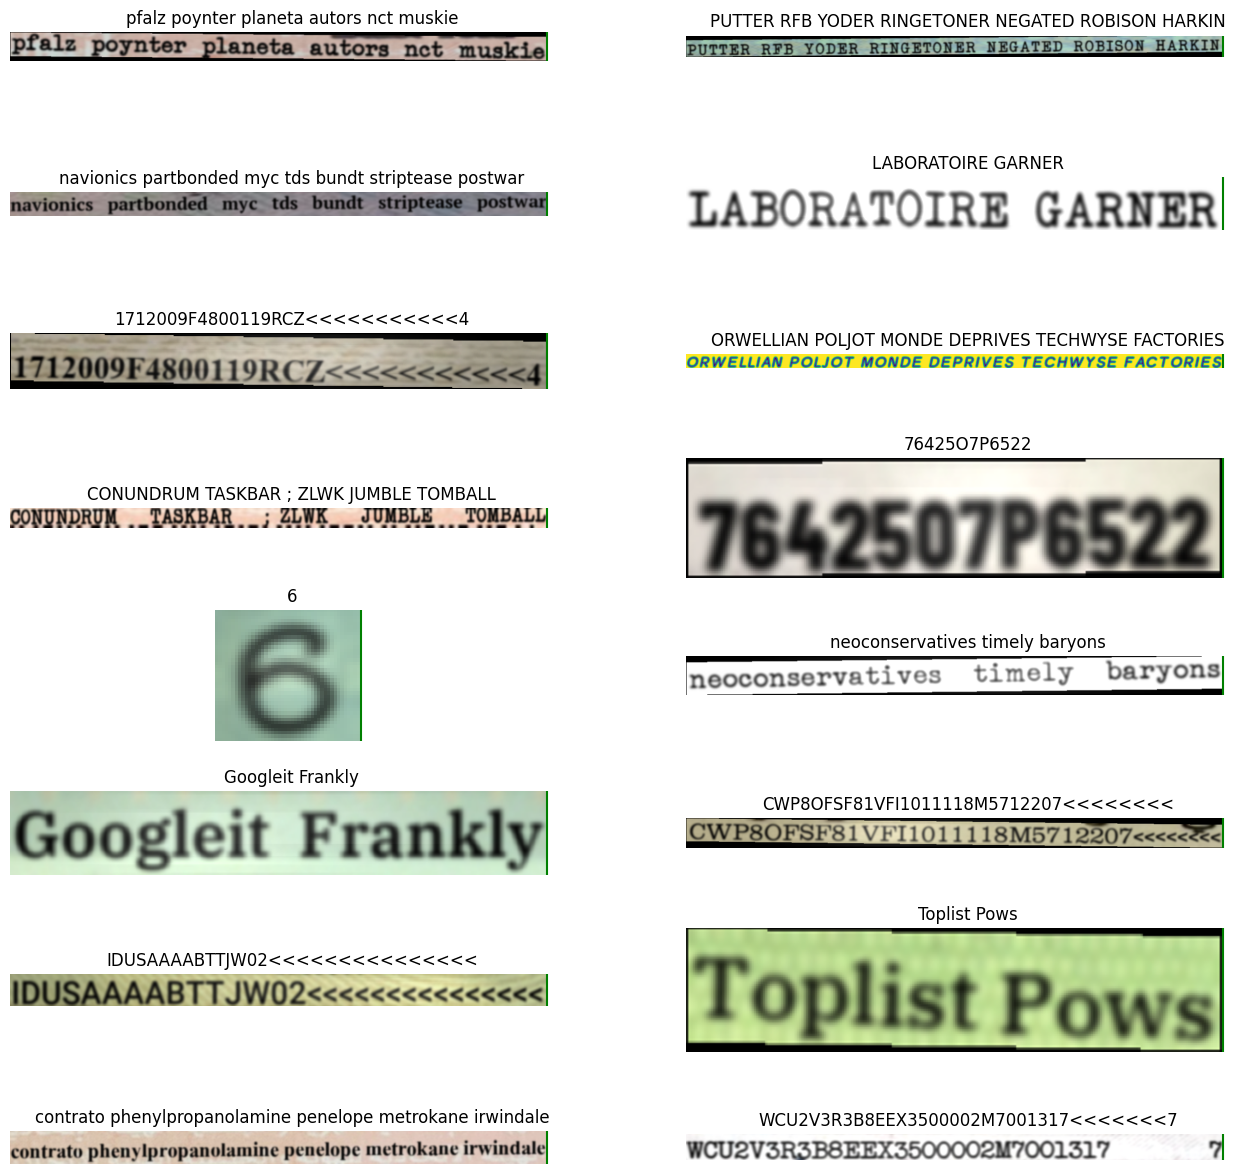

In [5]:
plt.figure(figsize=(16, 16))
for i in range(16):
    text, img = get_sample(MAX_NUM_WORDS, FONTS_LIST)
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(img)
    plt.axvline(x=img.size[0], color='g', label='axvline - full height')
    plt.title(text)
    plt.axis("off")
plt.show()

In [5]:
from tqdm import tqdm
from atpbar import atpbar
import os
import multiprocessing
from threading import Thread


NUMBER_IMAGES_TO_GENERATE = 100000
TRAIN_TEST_SPLIT_PERCENTAGE = 0.15
NUMBER_THREADS = 10

os.makedirs(os.path.join(OUTPUT_TEST_PATH, "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_TRAIN_PATH, "images"), exist_ok=True)
    
    
def generate__(pid, num_images, train_path, test_path, max_words, fonts_list, test_split):
    train_writer = open(os.path.join(train_path, f"{pid}_gt.txt"), "w")
    test_writer = open(os.path.join(test_path, f"{pid}_gt.txt"), "w")
    for image_index in atpbar(range(num_images), name=f'Job {pid}'):
        text, img = get_sample(max_words, fonts_list, add_reflection_effect=False)
        image_name = f"{pid}_{image_index}_Synthetic_En.jpg"
        if image_index % int(1/test_split) == 0:
            # put in test
            image_path = os.path.join(test_path, "images", image_name)
            img.convert('RGB').save(image_path)
            test_writer.write(f"{image_name}\t{text}\n")
        else:
            # put in train
            image_path = os.path.join(train_path, "images", image_name)
            img.convert('RGB').save(image_path)
            train_writer.write(f"{image_name}\t{text}\n")
    train_writer.close()
    test_writer.close()


if __name__ == "__main__":
    processes = []
    num_images_per_process = int(NUMBER_IMAGES_TO_GENERATE / NUMBER_THREADS)
    remain_images = NUMBER_IMAGES_TO_GENERATE % NUMBER_THREADS

    threads = [None] * NUMBER_THREADS
    for pid in range(NUMBER_THREADS):
        threads[pid] = Thread(
            target=generate__, 
            args=(
                pid,
                (num_images_per_process + remain_images) if pid == 0 else num_images_per_process,
                OUTPUT_TRAIN_PATH,
                OUTPUT_TEST_PATH,
                MAX_NUM_WORDS,
                FONTS_LIST,
                TRAIN_TEST_SPLIT_PERCENTAGE
            )
        )
        threads[pid].start()
    
    # join threads
    for thread in threads:
        thread.join()
        
    print("Merging GTs...")
    train_writer = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "w")
    test_writer = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "w")    
    train_records, test_records = 0, 0
    for path in [OUTPUT_TRAIN_PATH, OUTPUT_TEST_PATH]:
        for pid in range(NUMBER_THREADS):
            with open(os.path.join(path, f"{pid}_gt.txt"), "r") as reader:
                for line in reader.readlines():
                    if "train" in path:
                        train_writer.write(line)
                        train_records += 1
                    else:
                        test_writer.write(line)
                        test_records += 1                    
    train_writer.close()
    test_writer.close()
    
    # remove other GTs
    for path in [OUTPUT_TRAIN_PATH, OUTPUT_TEST_PATH]:
        for pid in range(NUMBER_THREADS):
            os.remove(os.path.join(path, f"{pid}_gt.txt"))
                        
    print(f"Number of Train records {train_records}")
    print(f"Number of Test records {test_records}")

VBox()

Merging GTs...
Number of Train records 83330
Number of Test records 16670


### Generate Dictionary


In [6]:
OUTPUT_PATH_DICT = os.path.join(OUTPUT_PATH, "dict_Synthetic_En.txt")

test_reader = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "r")
train_reader = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "r")

dict_list = []
for reader in [test_reader, train_reader]:
    for line in reader.readlines():
        _, text = line.split("\t")
        for char in text.strip("\n"):
            if char not in dict_list:
                dict_list.append(char)

dict_list = sorted(dict_list)
with open(OUTPUT_PATH_DICT, "w") as writer:
    for char in dict_list:
        writer.write(f"{char}\n")

In [7]:
max_len = 0
text = ''

test_reader = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "r")
train_reader = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "r")

for reader in [test_reader, train_reader]:
    for line in reader.readlines():
        _, t = line.split("\t")
        if len(t) > max_len:
            max_len = len(t)
            text = t
            
print(max_len, text)

94 W AADZ FACULDADE WEBTOPICEDITTEMPLATE APPREHENSIONS TECHNICALITY LPSYCHOANALYTIC T HANDCRAFTS

